In [1]:
import sys
import os
try:
    import warnings                                                   
    warnings.filterwarnings('ignore')     
    import pandas as pd       
    import numpy as np
    import sqlite3
    import watermark
    import pymc3 as pm
    from pymc3.math import invlogit
    import theano.tensor as tt
    import xarray as xr
    import arviz as az
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.cbook as cbook
    # import jotaviz
    from datetime import datetime, timedelta
    from scipy.special import expit as logistic
    from IPython.display import display, HTML
    from dateutil.relativedelta import relativedelta

except ImportError:
    print("Error: missing one of the libraries..")
    sys.exit()

sys.path.append('../..')

%matplotlib inline

# hide
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print(os.getcwd())
print(sys.argv[0])
print(os.path.dirname(os.path.realpath('__file__')))
print('Running on pymc3 v{}'.format(pm.__version__))
print('Running on arviz v{}'.format(az.__version__))

PRIOR_N = 50.
ELECTION_DATE = '2021-12-30'

/Users/marcelino/dmarcelinobr/pollbase/dashboards/models
/Users/marcelino/Library/Python/3.8/lib/python/site-packages/ipykernel_launcher.py
/Users/marcelino/dmarcelinobr/pollbase/dashboards/models
Running on pymc3 v3.11.4
Running on arviz v0.11.2


In [2]:

def exp_decay(data_date, election_date):
    '''Weights polls with exponential decay setting 30 days before election at 0.5 weight'''
    # calculate time delta 
    td = (election_date - data_date).days
    
    # calculate the exponential decay
    return 0.5 ** (td / 30.)

In [3]:
con = sqlite3.connect('../../pollingpoint.db')

file_long = pd.read_sql(""" SELECT data_ini, data_fim, empresa,
turno, candidato, voto, erro, amostra, tipo, modo FROM intencao WHERE tipo = 'Bolsonaro x Lula' 
OR  tipo = 'Lula x Moro' AND cargo = 'Presidente' ORDER BY data_fim;""", con=con) 

con.close()

In [4]:
# Converte para datetime 
file_long["data_fim"] = pd.to_datetime(file_long["data_fim"])

# sort by field date
file_long = file_long.sort_index(axis=0)

# Create indecisos e branco/nulo
file_long["candidato"] = file_long["candidato"].replace("NS/NR", "Indecisos")
file_long["candidato"] = file_long["candidato"].replace("Branco/Nulo/NS/NR", "Branco/Nulo")

# Replace NA with 1000 interviews 
file_long["amostra"] = file_long["amostra"].replace(np.nan, 1000)

# Convert vote intention rates to proportion 
# file_long[["voto", "erro"]] = (file_long[["voto", "erro"]].copy()/100)

data = file_long.query("tipo == 'Bolsonaro x Lula' | tipo == 'Lula x Moro'")

data.head()

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo
0,2020-08-24,2020-08-31,IDEIA,2,Bolsonaro,42.0,3.0,1235,Bolsonaro x Lula,CATI
1,2020-08-24,2020-08-31,IDEIA,2,Branco/Nulo,21.0,3.0,1235,Bolsonaro x Lula,CATI
2,2020-08-24,2020-08-31,IDEIA,2,Lula,31.0,3.0,1235,Bolsonaro x Lula,CATI
3,2020-08-24,2020-08-31,IDEIA,2,Indecisos,6.0,3.0,1235,Bolsonaro x Lula,CATI
4,2021-03-08,2021-03-10,Atlas,2,Bolsonaro,38.8,3.0,3721,Bolsonaro x Lula,Online


In [5]:
candidatos = data['candidato'].unique().tolist()
candidatos 


['Bolsonaro', 'Branco/Nulo', 'Lula', 'Indecisos', 'Moro']

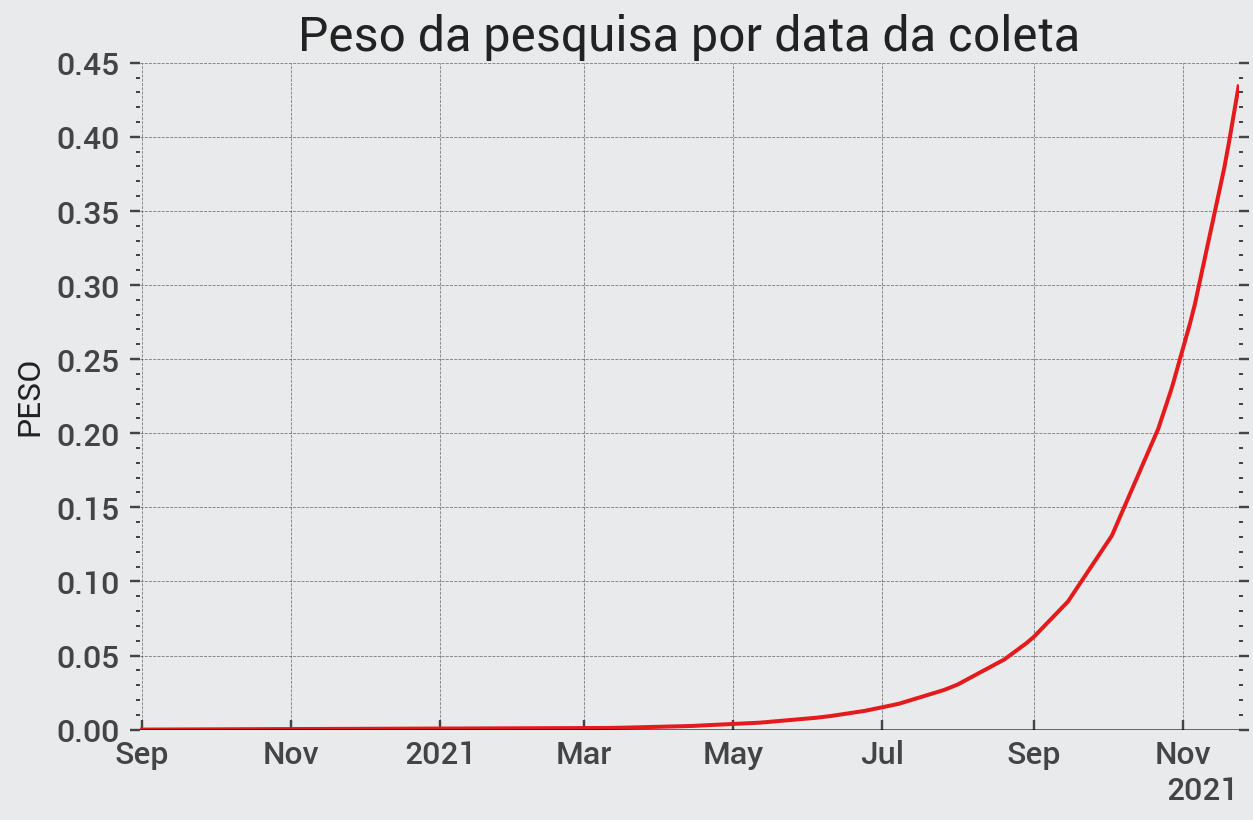

In [6]:
# weight the poll by end date
data['weight'] = data['data_fim'].apply(exp_decay, args=(datetime.strptime(ELECTION_DATE, '%Y-%m-%d'),))
# data['weight'] = 1

    
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.plot(data.data_fim, data.weight, linewidth=2)
    ax.set_ylabel(f'PESO')
    ax.set_title(f'Peso da pesquisa por data da coleta', fontsize=24)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
    # Remove the label of the x-axis
    ax.xaxis.label.set_visible(False)
    fig.tight_layout();
    plt.savefig('../figures/exponential_decay.png', dpi=300)

In [7]:
# apply weight to sample size
data['amostra'] = data['amostra'] * data['weight']
data

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
0,2020-08-24,2020-08-31,IDEIA,2,Bolsonaro,42.0,3.0,0.016405,Bolsonaro x Lula,CATI,0.000013
1,2020-08-24,2020-08-31,IDEIA,2,Branco/Nulo,21.0,3.0,0.016405,Bolsonaro x Lula,CATI,0.000013
2,2020-08-24,2020-08-31,IDEIA,2,Lula,31.0,3.0,0.016405,Bolsonaro x Lula,CATI,0.000013
3,2020-08-24,2020-08-31,IDEIA,2,Indecisos,6.0,3.0,0.016405,Bolsonaro x Lula,CATI,0.000013
4,2021-03-08,2021-03-10,Atlas,2,Bolsonaro,38.8,3.0,4.078790,Bolsonaro x Lula,Online,0.001096
...,...,...,...,...,...,...,...,...,...,...,...
146,2021-11-22,2021-11-24,PoderData,2,Lula,54.0,2.0,1088.188204,Bolsonaro x Lula,IVR,0.435275
147,2021-11-22,2021-11-24,PoderData,2,Lula,48.0,2.0,1088.188204,Lula x Moro,IVR,0.435275
148,2021-11-22,2021-11-24,PoderData,2,Moro,31.0,2.0,1088.188204,Lula x Moro,IVR,0.435275
149,2021-11-22,2021-11-24,PoderData,2,Indecisos,1.0,2.0,1088.188204,Bolsonaro x Lula,IVR,0.435275


# Bolsonaro (PL) vs Lula (PT)

In [8]:
# Nov 3, 2020 results used as prior (total party support used as prior)
b_pct = .40
l_pct = .45

# normalize the split because the race is only between the two now
b_pct_norm = b_pct / (b_pct + l_pct)
l_pct_norm = l_pct / (b_pct + l_pct)

b_pct_norm, l_pct_norm

(0.47058823529411764, 0.5294117647058824)

In [9]:
lula_polls = data.query("tipo == 'Bolsonaro x Lula' & candidato == 'Lula'")
# only use most recent poll from empresa that do multiple
lula_polls = lula_polls.sort_values('data_fim').drop_duplicates('empresa', keep='last')
lula_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
21,2021-06-01,2021-06-04,Ranking Brasil,2,Lula,47.07,2.5,23.985326,Bolsonaro x Lula,CATI,0.007995
33,2021-06-22,2021-06-24,IDEIA,2,Lula,44.00,3.0,15.229732,Bolsonaro x Lula,CATI,0.012691
52,2021-07-07,2021-07-08,Orbis,2,Lula,46.80,1.8,52.475101,Bolsonaro x Lula,Internet,0.017538
60,2021-07-26,2021-07-29,Atlas,2,Lula,49.20,2.0,82.168989,Bolsonaro x Lula,Online,0.028491
83,2021-09-13,2021-09-15,Datafolha,2,Lula,56.00,2.0,316.717158,Bolsonaro x Lula,Presencial,0.086370
104,2021-10-25,2021-10-28,Ipespe,2,Lula,50.00,3.2,233.258248,Bolsonaro x Lula,CATI,0.233258
109,2021-10-30,2021-11-04,Vox Populi,2,Lula,52.00,2.2,548.412490,Bolsonaro x Lula,Presencial,0.274206
114,2021-11-03,2021-11-06,Quaest,2,Lula,57.00,2.2,592.441177,Bolsonaro x Lula,Presencial,0.287175
122,2021-11-16,2021-11-18,Ponteio,2,Lula,50.00,3.0,378.929142,Bolsonaro x Lula,CATI,0.378929
130,2021-11-16,2021-11-19,Paraná,2,Lula,42.50,2.0,783.328105,Bolsonaro x Lula,Presencial,0.387786


In [10]:
bolsonaro_polls = data.query("tipo == 'Bolsonaro x Lula' & candidato == 'Bolsonaro'")
# only use most recent poll from pollsters that do multiple
bolsonaro_polls = bolsonaro_polls.sort_values('data_fim').drop_duplicates('empresa', keep='last')
bolsonaro_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
19,2021-06-01,2021-06-04,Ranking Brasil,2,Bolsonaro,35.13,2.5,23.985326,Bolsonaro x Lula,CATI,0.007995
30,2021-06-22,2021-06-24,IDEIA,2,Bolsonaro,39.00,3.0,15.229732,Bolsonaro x Lula,CATI,0.012691
50,2021-07-07,2021-07-08,Orbis,2,Bolsonaro,38.90,1.8,52.475101,Bolsonaro x Lula,Internet,0.017538
58,2021-07-26,2021-07-29,Atlas,2,Bolsonaro,38.10,2.0,82.168989,Bolsonaro x Lula,Online,0.028491
81,2021-09-13,2021-09-15,Datafolha,2,Bolsonaro,31.00,2.0,316.717158,Bolsonaro x Lula,Presencial,0.086370
101,2021-10-25,2021-10-28,Ipespe,2,Bolsonaro,32.00,3.2,233.258248,Bolsonaro x Lula,CATI,0.233258
107,2021-10-30,2021-11-04,Vox Populi,2,Bolsonaro,24.00,2.2,548.412490,Bolsonaro x Lula,Presencial,0.274206
111,2021-11-03,2021-11-06,Quaest,2,Bolsonaro,27.00,2.2,592.441177,Bolsonaro x Lula,Presencial,0.287175
119,2021-11-16,2021-11-18,Ponteio,2,Bolsonaro,32.00,3.0,378.929142,Bolsonaro x Lula,CATI,0.378929
127,2021-11-16,2021-11-19,Paraná,2,Bolsonaro,35.60,2.0,783.328105,Bolsonaro x Lula,Presencial,0.387786


In [11]:
poll_normalizer = lula_polls[['empresa', 'voto', 'data_fim']].merge(bolsonaro_polls[['empresa', 'voto', 'data_fim']], on=['empresa', 'data_fim'])
poll_normalizer['normalizer'] = poll_normalizer['voto_x'] + poll_normalizer['voto_y']
poll_normalizer['voto_x'] /= poll_normalizer['normalizer']
poll_normalizer['voto_y'] /= poll_normalizer['normalizer']
poll_normalizer 

,empresa,voto_x,data_fim,voto_y,normalizer
0,Ranking Brasil,0.572628,2021-06-04,0.427372,82.2
1,IDEIA,0.530120,2021-06-24,0.469880,83.0
2,Orbis,0.546091,2021-07-08,0.453909,85.7
3,Atlas,0.563574,2021-07-29,0.436426,87.3
4,Datafolha,0.643678,2021-09-15,0.356322,87.0
5,Ipespe,0.609756,2021-10-28,0.390244,82.0
6,Vox Populi,0.684211,2021-11-04,0.315789,76.0
7,Quaest,0.678571,2021-11-06,0.321429,84.0
8,Ponteio,0.609756,2021-11-18,0.390244,82.0
9,Paraná,0.544174,2021-11-19,0.455826,78.1


In [12]:
# add in the normalized values to lula polls
for _, norm_row in poll_normalizer.iterrows():
    _date, _empresa, _voto = norm_row['data_fim'], norm_row['empresa'], norm_row['voto_x']
    lula_polls.loc[(lula_polls.data_fim == _date) & (lula_polls.empresa == _empresa), 'voto'] = _voto
    
lula_polls['num_votos'] = lula_polls['amostra'] * lula_polls['voto']
lula_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight,num_votos
21,2021-06-01,2021-06-04,Ranking Brasil,2,Lula,0.572628,2.5,23.985326,Bolsonaro x Lula,CATI,0.007995,13.734663
33,2021-06-22,2021-06-24,IDEIA,2,Lula,0.530120,3.0,15.229732,Bolsonaro x Lula,CATI,0.012691,8.073593
52,2021-07-07,2021-07-08,Orbis,2,Lula,0.546091,1.8,52.475101,Bolsonaro x Lula,Internet,0.017538,28.656181
60,2021-07-26,2021-07-29,Atlas,2,Lula,0.563574,2.0,82.168989,Bolsonaro x Lula,Online,0.028491,46.308296
83,2021-09-13,2021-09-15,Datafolha,2,Lula,0.643678,2.0,316.717158,Bolsonaro x Lula,Presencial,0.086370,203.863918
104,2021-10-25,2021-10-28,Ipespe,2,Lula,0.609756,3.2,233.258248,Bolsonaro x Lula,CATI,0.233258,142.230639
109,2021-10-30,2021-11-04,Vox Populi,2,Lula,0.684211,2.2,548.412490,Bolsonaro x Lula,Presencial,0.274206,375.229598
114,2021-11-03,2021-11-06,Quaest,2,Lula,0.678571,2.2,592.441177,Bolsonaro x Lula,Presencial,0.287175,402.013656
122,2021-11-16,2021-11-18,Ponteio,2,Lula,0.609756,3.0,378.929142,Bolsonaro x Lula,CATI,0.378929,231.054355
130,2021-11-16,2021-11-19,Paraná,2,Lula,0.544174,2.0,783.328105,Bolsonaro x Lula,Presencial,0.387786,426.266894


In [13]:
# group by pollster
lula_bolsonaro_empresas = (
    lula_polls[['empresa', 'amostra', 'num_votos']]
    .groupby('empresa')
    .agg(np.sum)
)
lula_bolsonaro_empresas

,amostra,num_votos
empresa,,
Atlas,82.168989,46.308296
Datafolha,316.717158,203.863918
Futura,793.700526,450.924548
IDEIA,15.229732,8.073593
Ipespe,233.258248,142.230639
Orbis,52.475101,28.656181
Paraná,783.328105,426.266894
PoderData,1088.188204,691.319565
Ponteio,378.929142,231.054355


In [14]:
# tune n for how much we want the model to 
alpha = int(l_pct_norm * PRIOR_N)
beta = PRIOR_N - alpha

alpha, beta

(26, 24.0)

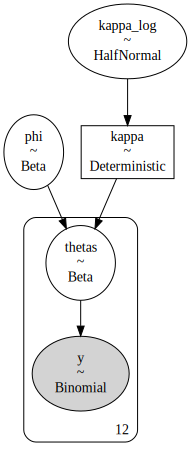

In [15]:
with pm.Model() as lula_bolsonaro_model:
    
    phi = pm.Beta('phi', alpha=alpha, beta=beta)

    kappa_log = pm.HalfNormal('kappa_log', sigma=10)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta(
        'thetas', 
        alpha=phi*kappa, 
        beta=(1.0-phi)*kappa, 
        shape=len(lula_bolsonaro_empresas)
    )
    
    y = pm.Binomial(
        'y', 
        n=lula_bolsonaro_empresas['amostra'], 
        p=thetas, 
        observed=lula_bolsonaro_empresas['num_votos']
    )

# Save imagem
pc = pm.model_to_graphviz(lula_bolsonaro_model)
pc.render("../figures/lula_bolsonaro_model", format="png")

pm.model_to_graphviz(lula_bolsonaro_model)

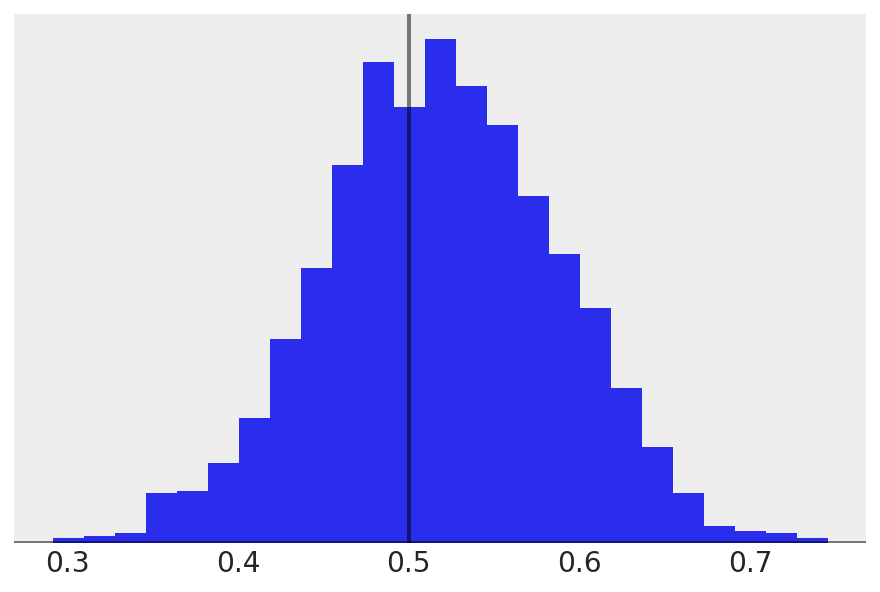

In [16]:
with lula_bolsonaro_model:
    lula_bolsonaro_prior = pm.sample_prior_predictive(samples=2000)
    
plt.hist(lula_bolsonaro_prior['phi'], bins=25)
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.grid(linestyle=':')
plt.yticks([])
plt.show()

In [17]:
# Explore and Sample the Parameter Space
with lula_bolsonaro_model:
    # step = pm.Metropolis()
    lula_bolsonaro_samples = pm.sample(2000, tune=4000, cores=4, chains=6, target_accept=0.999) 
    # post_pred = pm.sample_posterior_predictive(samples, 200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [thetas, kappa_log, phi]


Sampling 6 chains for 4_000 tune and 2_000 draw iterations (24_000 + 12_000 draws total) took 167 seconds.


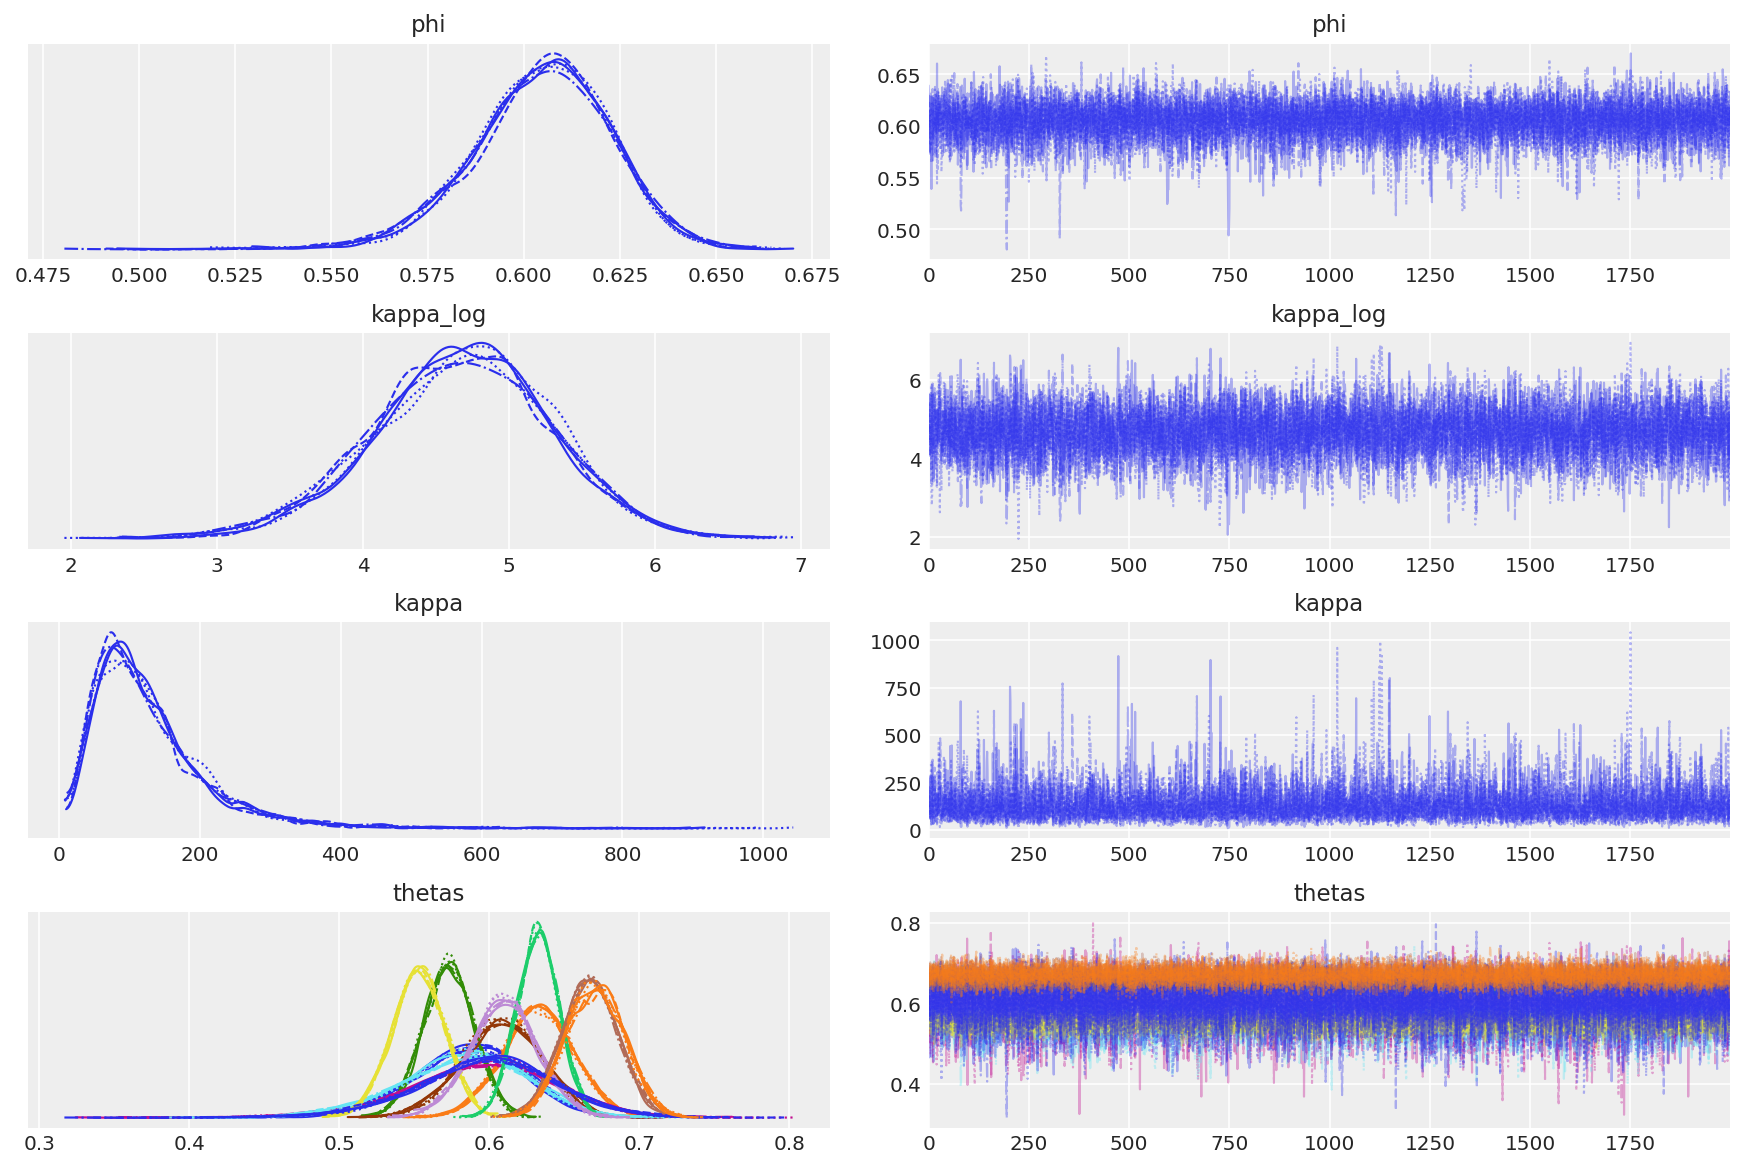

In [18]:
pm.traceplot(lula_bolsonaro_samples)
plt.show()

In [19]:
pm.summary(lula_bolsonaro_samples, hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi,0.605,0.018,0.570,0.637,0.000,0.000,8623.0,6837.0,1.0
kappa_log,4.674,0.616,3.483,5.795,0.009,0.006,5060.0,6662.0,1.0
kappa,128.897,85.007,17.383,273.597,1.187,0.847,5060.0,6662.0,1.0
thetas[0],0.586,0.037,0.511,0.650,0.000,0.000,10747.0,8495.0,1.0
thetas[1],0.633,0.024,0.587,0.677,0.000,0.000,14763.0,8307.0,1.0
thetas[2],0.573,0.017,0.541,0.605,0.000,0.000,11935.0,8088.0,1.0
thetas[3],0.595,0.050,0.500,0.689,0.000,0.000,11186.0,6952.0,1.0
thetas[4],0.608,0.027,0.558,0.659,0.000,0.000,13835.0,8346.0,1.0
thetas[5],0.583,0.042,0.502,0.661,0.000,0.000,10303.0,8465.0,1.0
thetas[6],0.553,0.018,0.521,0.587,0.000,0.000,12096.0,7901.0,1.0


In [20]:
map_estimate = pm.find_MAP(model=lula_bolsonaro_model)
map_estimate['phi']

array(0.61357661)

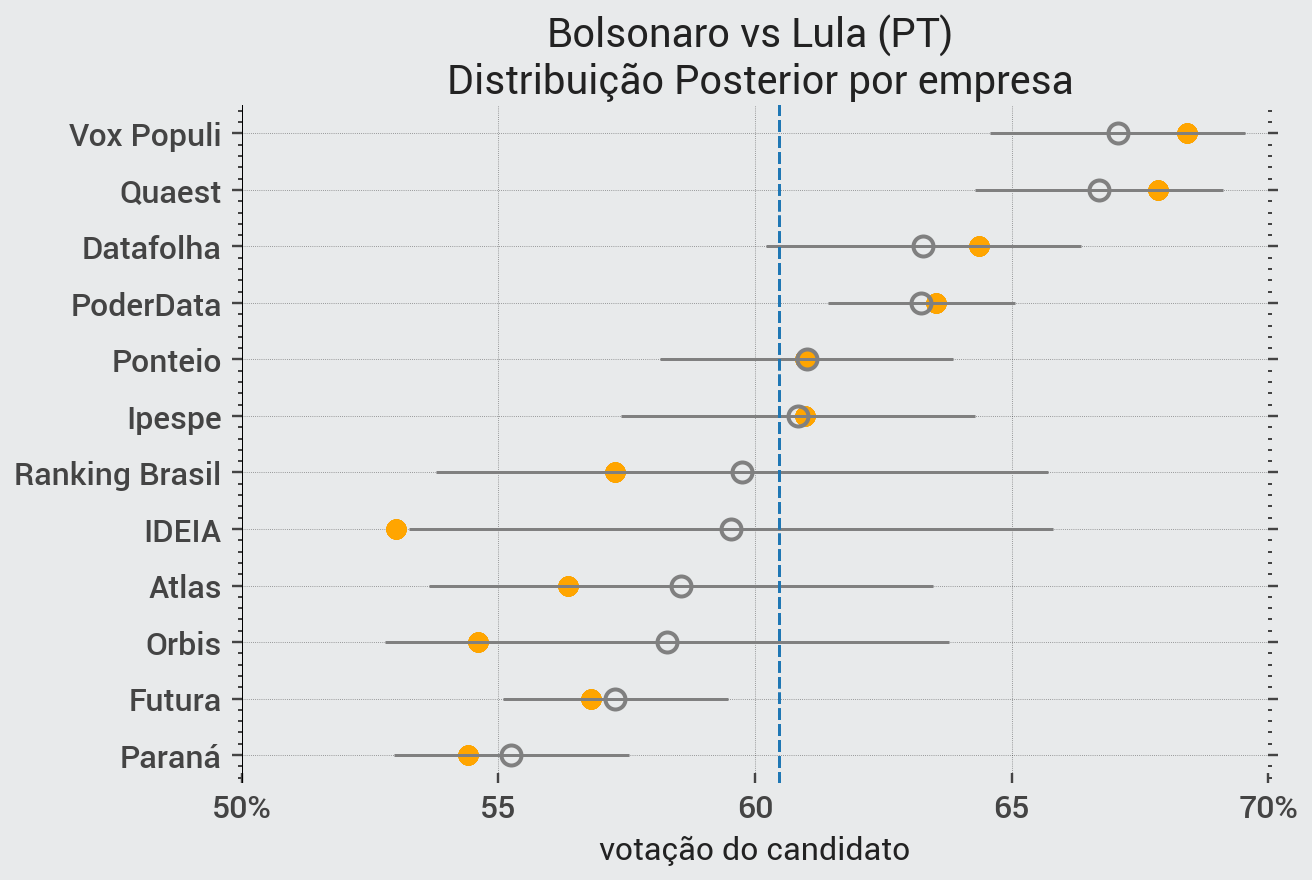

In [21]:
import scipy.stats as stats

medians = []
errs = []
labels = []
for empresa_idx in range(lula_bolsonaro_samples['thetas'].shape[1]):
    _median = np.mean(lula_bolsonaro_samples['thetas'][:,empresa_idx])
    lower, _ = np.percentile(lula_bolsonaro_samples['thetas'][:,empresa_idx], (10, 90))
    err = _median - lower
    
    medians.append(_median)
    errs.append(err)
    labels.append(lula_bolsonaro_empresas.index.tolist()[empresa_idx])
    
errs = [x for _,x in sorted(zip(medians, errs))]
labels = [x for _,x in sorted(zip(medians, labels))]
medians = sorted(medians)
#print(medians)


with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    #medians, errs, labels
    for idx, _median in enumerate(medians):
        plt.errorbar(x=_median, y=idx, xerr=errs[idx], fmt='o', color='gray')
        for empresa_idx, empresa in enumerate(labels):
            plt.scatter(
                x=(
                    lula_bolsonaro_empresas[lula_bolsonaro_empresas.index == empresa]['num_votos'] / 
                    lula_bolsonaro_empresas[lula_bolsonaro_empresas.index == empresa]['amostra']), 
                y=empresa_idx, color='orange')
        plt.axvline(x=0.5, color='black', alpha=0.9, linewidth=1)
        plt.axvline(x=np.mean(lula_bolsonaro_samples['phi']), linestyle='--', color='tab:blue')
        plt.grid(linestyle=':')
        plt.yticks(np.arange(len(lula_bolsonaro_empresas)), labels)
        plt.xlabel('votação do candidato')
        plt.title('Bolsonaro vs Lula (PT) \n Distribuição Posterior por empresa', fontsize=20)
        ax.set_xticks(ticks = [.50, .55, .60, .65, .70])
        ax.set_xticklabels(labels = ['50%', '55', '60', '65', '70%'])
        yticks, yticklabels = plt.yticks()
        ymin = (3*yticks[0] - yticks[1])/2.
        # shaft half a step to the right
        ymax = (3*yticks[-1] - yticks[-2])/2.
        plt.ylim(ymin, ymax)
        plt.yticks(yticks)

plt.savefig('../figures/lula_bolsonaro_tendendcia_empresa.png', dpi=300)

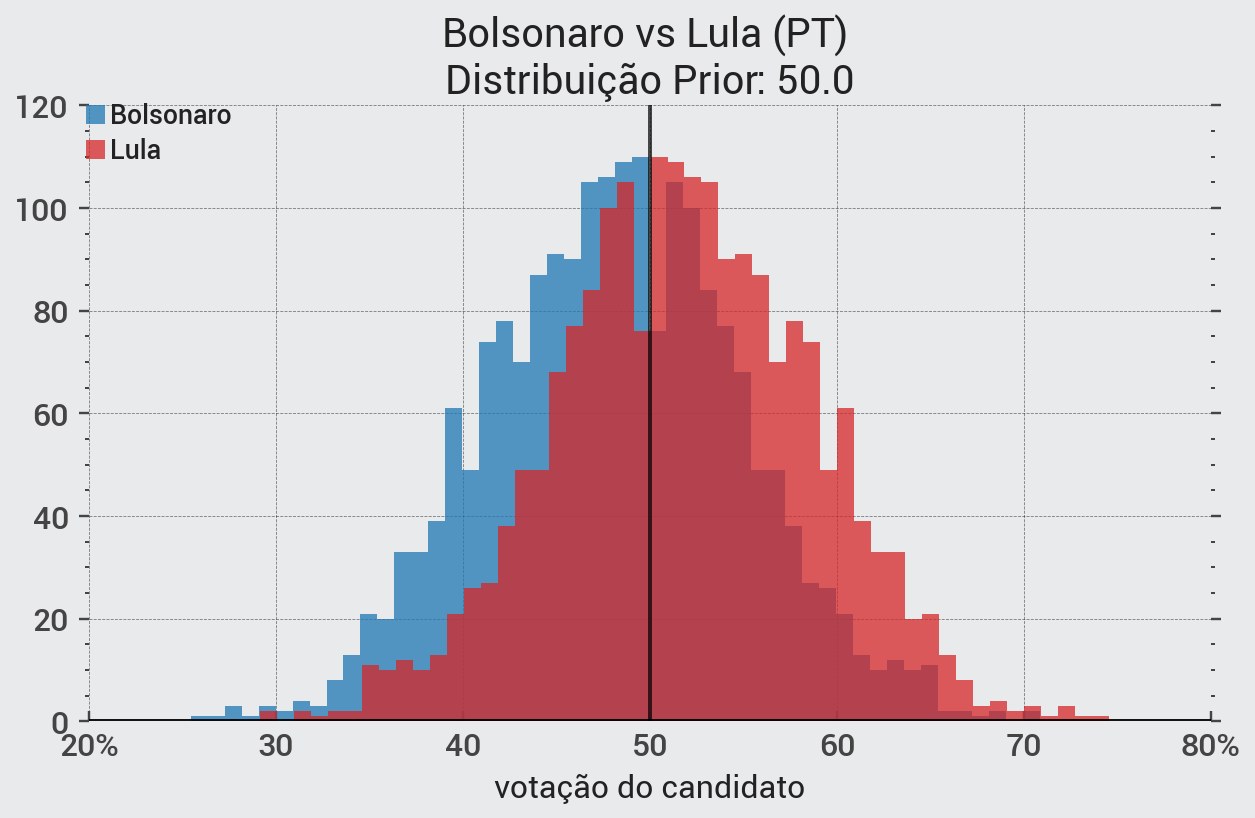

In [45]:

with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.hist(1. - (lula_bolsonaro_prior['phi']), color='tab:blue', alpha=0.75, bins=50, label='Bolsonaro')
    ax.hist(lula_bolsonaro_prior['phi'], color='tab:red', alpha=0.75, bins=50, label='Lula')
    ax.set_title('Bolsonaro vs Lula (PT) \nDistribuição Prior: {}'.format(PRIOR_N), fontsize=20)
    ax.set_xlabel(f'votação do candidato')
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.axvline(x = 0.5, color = 'black', linewidth = 2, alpha = .7)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xticks(ticks = [.20, .30, .40, .50, .60, .70, .80])
    ax.set_xticklabels(labels = ['20%', '30', '40', '50', '60', '70', '80%'])
    #ax.grid(linestyle=':')
    ax.legend(loc="upper left")
    fig.tight_layout();
    # save figure 
    plt.savefig('../figures/bolsonaro_lula_{}-priors.png'.format(PRIOR_N))

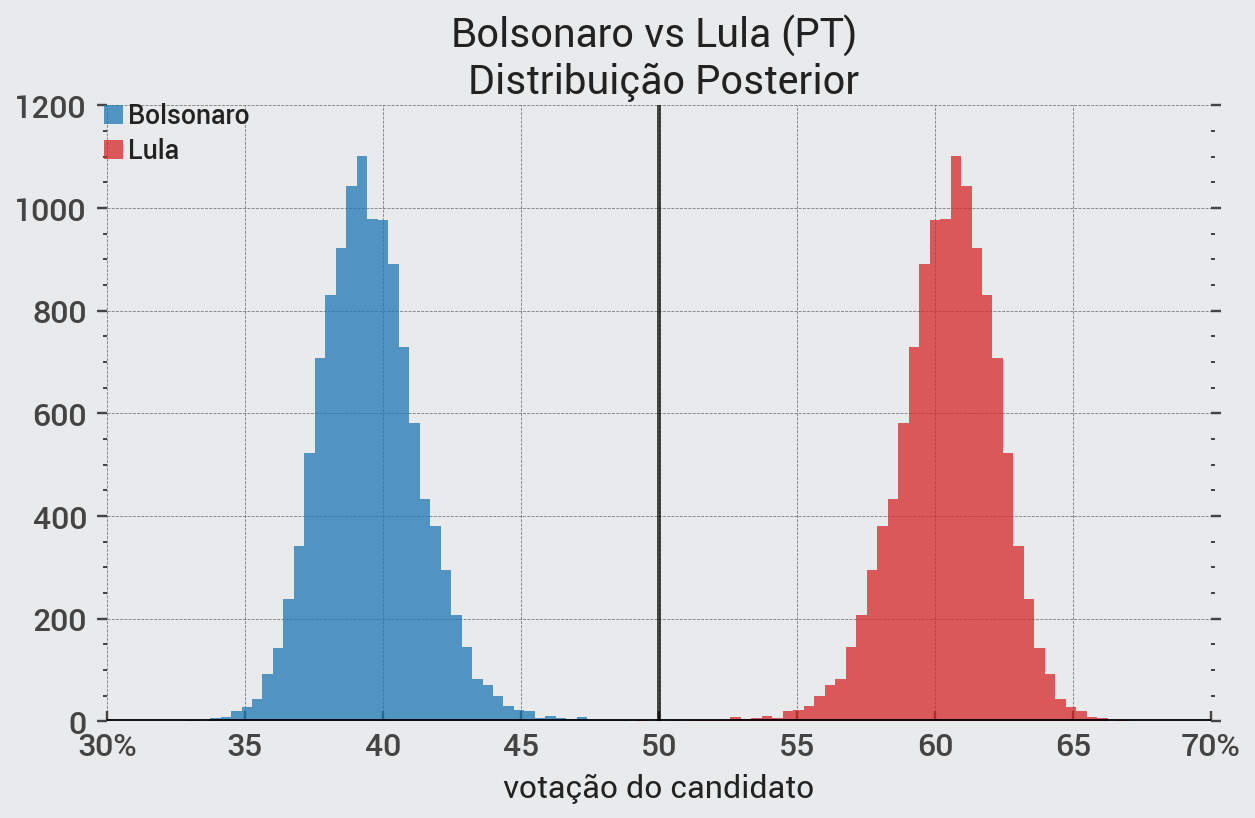

In [37]:
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.hist(1. - (lula_bolsonaro_samples['phi']), color='tab:blue', alpha=0.75, bins=50, label='Bolsonaro')
    ax.hist(lula_bolsonaro_samples['phi'], color='tab:red', alpha=0.75, bins=50, label='Lula')
    ax.set_title('Bolsonaro vs Lula (PT) \n Distribuição Posterior', fontsize=20)
    ax.set_xlabel(f'votação do candidato')
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.axvline(x = 0.5, color = 'black', linewidth = 2, alpha = .7)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xticks(ticks = [.30, .35, .40, .45, .50, .55, .60, .65, .70])
    ax.set_xticklabels(labels = ['30%', '35', '40', '45', '50', '55', '60', '65', '70%'])
    # ax.grid(linestyle=':')
    ax.legend(loc="upper left")
    fig.tight_layout();
    # save figure 
    plt.savefig('../figures/bolsonaro_lula_posteriors.png')


In [24]:
print("Probabilidade de vitória de Lula no 2º turno:", round(np.mean(lula_bolsonaro_samples['phi'] > 0.55),3));
print("Probabilidade de vitória de Bolsonaro no 2º turno:", round(np.mean(1. - lula_bolsonaro_samples['phi'] > 0.450),3))

Probabilidade de vitória de Lula no 2º turno: 0.993
Probabilidade de vitória de Bolsonaro no 2º turno: 0.007


# Lula (PT) vs Moro (PODE)

In [25]:
# Nov 3, 2020 results used as prior
l_pct = 0.45
m_pct = 0.40

# normalize the split because the race is only between the two now
l_pct_norm = l_pct / (l_pct + m_pct)
m_pct_norm = m_pct / (m_pct + l_pct)

l_pct_norm, m_pct_norm

(0.5294117647058824, 0.47058823529411764)

In [26]:
lula_polls = data.query("tipo == 'Lula x Moro' & candidato == 'Lula'")
# only use most recent poll from pollsters that do multiple
# lula_polls = lula_polls.sort_values('data_fim').drop_duplicates('empresa', keep='last')
lula_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
15,2021-05-11,2021-05-12,Datafolha,1,Lula,53.0,2.0,9.732285,Lula x Moro,Presencial,0.004699
28,2021-06-07,2021-06-10,Ipespe,2,Lula,43.0,3.2,9.183968,Lula x Moro,CATI,0.009184
34,2021-06-22,2021-06-24,IDEIA,2,Lula,44.0,3.0,15.229732,Lula x Moro,CATI,0.012691
44,2021-07-05,2021-07-07,Ipespe,2,Lula,48.0,3.2,17.137890,Lula x Moro,CATI,0.017138
65,2021-07-29,2021-08-01,Quaest,2,Lula,54.0,3.0,45.804374,Lula x Moro,Presencial,0.030536
89,2021-09-30,2021-10-03,Quaest,2,Lula,52.0,3.0,268.107295,Lula x Moro,Presencial,0.130912
105,2021-10-25,2021-10-28,Ipespe,2,Lula,52.0,3.2,233.258248,Lula x Moro,CATI,0.233258
115,2021-11-03,2021-11-06,Quaest,2,Lula,57.0,2.2,592.441177,Lula x Moro,Presencial,0.287175
123,2021-11-16,2021-11-18,Ponteio,2,Lula,45.0,3.0,378.929142,Lula x Moro,CATI,0.378929
131,2021-11-16,2021-11-19,Paraná,2,Lula,40.7,2.0,783.328105,Lula x Moro,Presencial,0.387786


In [27]:
moro_polls = data.query("tipo == 'Lula x Moro' & candidato == 'Moro'")
# only use most recent poll from pollsters that do multiple
# moro_polls = moro_polls.sort_values('data_fim').drop_duplicates('empresa', keep='last')
moro_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
16,2021-05-11,2021-05-12,Datafolha,1,Moro,33.0,2.0,9.732285,Lula x Moro,Presencial,0.004699
29,2021-06-07,2021-06-10,Ipespe,2,Moro,35.0,3.2,9.183968,Lula x Moro,CATI,0.009184
35,2021-06-22,2021-06-24,IDEIA,2,Moro,39.0,3.0,15.229732,Lula x Moro,CATI,0.012691
45,2021-07-05,2021-07-07,Ipespe,2,Moro,35.0,3.2,17.137890,Lula x Moro,CATI,0.017138
66,2021-07-29,2021-08-01,Quaest,2,Moro,26.0,2.2,45.804374,Lula x Moro,Presencial,0.030536
90,2021-09-30,2021-10-03,Quaest,2,Moro,26.0,2.2,268.107295,Lula x Moro,Presencial,0.130912
106,2021-10-25,2021-10-28,Ipespe,2,Moro,34.0,3.2,233.258248,Lula x Moro,CATI,0.233258
116,2021-11-03,2021-11-06,Quaest,2,Moro,22.0,2.2,592.441177,Lula x Moro,Presencial,0.287175
124,2021-11-16,2021-11-18,Ponteio,2,Moro,31.0,3.0,378.929142,Lula x Moro,CATI,0.378929
132,2021-11-16,2021-11-19,Paraná,2,Moro,29.8,2.0,783.328105,Lula x Moro,Presencial,0.387786


In [28]:
poll_normalizer = lula_polls[['empresa', 'voto', 'data_fim']].merge(moro_polls[['empresa', 'voto', 'data_fim']], on=['empresa', 'data_fim'])
poll_normalizer['normalizer'] = (poll_normalizer['voto_x'] + poll_normalizer['voto_y'])
poll_normalizer['voto_x'] /= poll_normalizer['normalizer']
poll_normalizer['voto_y'] /= poll_normalizer['normalizer']
poll_normalizer 

,empresa,voto_x,data_fim,voto_y,normalizer
0,Datafolha,0.616279,2021-05-12,0.383721,86.0
1,Ipespe,0.551282,2021-06-10,0.448718,78.0
2,IDEIA,0.530120,2021-06-24,0.469880,83.0
3,Ipespe,0.578313,2021-07-07,0.421687,83.0
4,Quaest,0.675000,2021-08-01,0.325000,80.0
5,Quaest,0.666667,2021-10-03,0.333333,78.0
6,Ipespe,0.604651,2021-10-28,0.395349,86.0
7,Quaest,0.721519,2021-11-06,0.278481,79.0
8,Ponteio,0.592105,2021-11-18,0.407895,76.0
9,Paraná,0.577305,2021-11-19,0.422695,70.5


In [29]:
# add in the normalized values to lula polls
for _, norm_row in poll_normalizer.iterrows():
    _date, _empresa, _voto = norm_row['data_fim'], norm_row['empresa'], norm_row['voto_x']
    lula_polls.loc[(lula_polls.data_fim == _date) & (lula_polls.empresa == _empresa), 'voto'] = _voto

lula_polls['num_votos'] = lula_polls['amostra'] * lula_polls['voto']
lula_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight,num_votos
15,2021-05-11,2021-05-12,Datafolha,1,Lula,0.616279,2.0,9.732285,Lula x Moro,Presencial,0.004699,5.997803
28,2021-06-07,2021-06-10,Ipespe,2,Lula,0.551282,3.2,9.183968,Lula x Moro,CATI,0.009184,5.062957
34,2021-06-22,2021-06-24,IDEIA,2,Lula,0.530120,3.0,15.229732,Lula x Moro,CATI,0.012691,8.073593
44,2021-07-05,2021-07-07,Ipespe,2,Lula,0.578313,3.2,17.137890,Lula x Moro,CATI,0.017138,9.911069
65,2021-07-29,2021-08-01,Quaest,2,Lula,0.675000,3.0,45.804374,Lula x Moro,Presencial,0.030536,30.917952
89,2021-09-30,2021-10-03,Quaest,2,Lula,0.666667,3.0,268.107295,Lula x Moro,Presencial,0.130912,178.738197
105,2021-10-25,2021-10-28,Ipespe,2,Lula,0.604651,3.2,233.258248,Lula x Moro,CATI,0.233258,141.039871
115,2021-11-03,2021-11-06,Quaest,2,Lula,0.721519,2.2,592.441177,Lula x Moro,Presencial,0.287175,427.457558
123,2021-11-16,2021-11-18,Ponteio,2,Lula,0.592105,3.0,378.929142,Lula x Moro,CATI,0.378929,224.365939
131,2021-11-16,2021-11-19,Paraná,2,Lula,0.577305,2.0,783.328105,Lula x Moro,Presencial,0.387786,452.219204


In [30]:
# group by pollster
lula_moro_empresas = (
    lula_polls[['empresa', 'amostra', 'num_votos']]
    .groupby('empresa')
    .agg(np.sum)
)
lula_moro_empresas

,amostra,num_votos
empresa,,
Datafolha,9.732285,5.997803
Futura,793.700526,461.177612
IDEIA,15.229732,8.073593
Ipespe,259.580106,156.013897
Paraná,783.328105,452.219204
PoderData,1088.188204,661.177643
Ponteio,378.929142,224.365939
Quaest,906.352846,637.113707


In [31]:
# tune n for how much we want the model to 
alpha = int(l_pct_norm * PRIOR_N)
beta = PRIOR_N - alpha

alpha, beta

(26, 24.0)

In [32]:
with pm.Model() as lula_moro_model:
    
    phi = pm.Beta('phi', alpha=alpha, beta=beta)

    kappa_log = pm.HalfNormal('kappa_log', sigma=10)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta(
        'thetas', 
        alpha=phi*kappa, 
        beta=(1.0-phi)*kappa, 
        shape=len(lula_moro_empresas)
    )
    
    y = pm.Binomial(
        'y', 
        n=lula_moro_empresas['amostra'], 
        p=thetas, 
        observed=lula_moro_empresas['num_votos']
    )

In [33]:
with lula_moro_model:
    lula_moro_prior = pm.sample_prior_predictive(samples=2000)

In [35]:
with lula_moro_model:
    step = pm.Metropolis()
    lula_moro_samples = pm.sample(draws=2000, tune=4000, cores=4, chains=6, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [thetas, kappa_log, phi]


Sampling 6 chains for 4_000 tune and 2_000 draw iterations (24_000 + 12_000 draws total) took 138 seconds.


In [ ]:
pm.summary(lula_moro_samples, hdi_prob=0.94)

In [38]:
map_estimate = pm.find_MAP(model=lula_moro_model)
map_estimate['phi']

array(0.60850282)

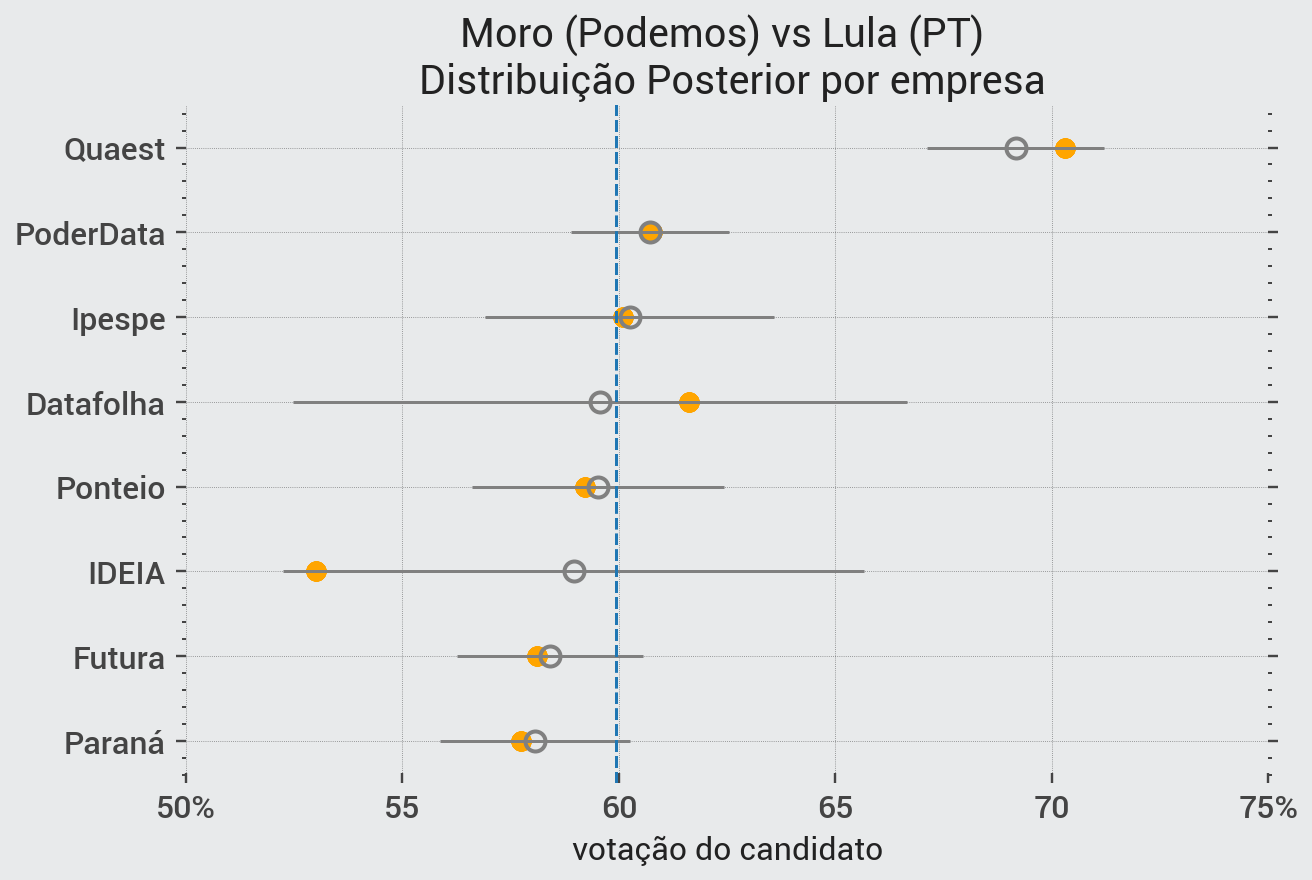

In [39]:
import scipy.stats as stats

medians = []
errs = []
labels = []
for empresa_idx in range(lula_moro_samples['thetas'].shape[1]):
    _median = np.mean(lula_moro_samples['thetas'][:,empresa_idx])
    lower, _ = np.percentile(lula_moro_samples['thetas'][:,empresa_idx], (10, 90))
    err = _median - lower
    
    medians.append(_median)
    errs.append(err)
    labels.append(lula_moro_empresas.index.tolist()[empresa_idx])
    
errs = [x for _,x in sorted(zip(medians, errs))]
labels = [x for _,x in sorted(zip(medians, labels))]
medians = sorted(medians)
#print(medians)

with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    #medians, errs, labels
    for idx, _median in enumerate(medians):
        plt.errorbar(x=_median, y=idx, xerr=errs[idx], fmt='o', color='gray')
        for empresa_idx, empresa in enumerate(labels):
            plt.scatter(
                x=(
                    lula_moro_empresas[lula_moro_empresas.index == empresa]['num_votos'] / 
                    lula_moro_empresas[lula_moro_empresas.index == empresa]['amostra']), 
                y=empresa_idx, color='orange')
        # plt.axvline(x=0.5, color='black', alpha=0.9, linewidth=1)
        plt.axvline(x=np.mean(lula_moro_samples['phi']), linestyle='--', color='tab:blue')
        plt.grid(linestyle=':')
        plt.yticks(np.arange(len(lula_moro_empresas)), labels)
        # plt.xlim([0.43, 0.57])
        plt.xlabel('votação do candidato')
        plt.title('Moro (Podemos) vs Lula (PT) \n Distribuição Posterior por empresa', fontsize=20)
        ax.set_xticks(ticks = [.50, .55, .60, .65, .70, .75])
        ax.set_xticklabels(labels = ['50%', '55', '60', '65', '70', '75%'])
        yticks, yticklabels = plt.yticks()
        ymin = (3*yticks[0] - yticks[1])/2.
        # shaft half a step to the right
        ymax = (3*yticks[-1] - yticks[-2])/2.
        plt.ylim(ymin, ymax)
        plt.yticks(yticks)

plt.savefig('../figures/lula_moro_tendendcia_empresa.png', dpi=300)

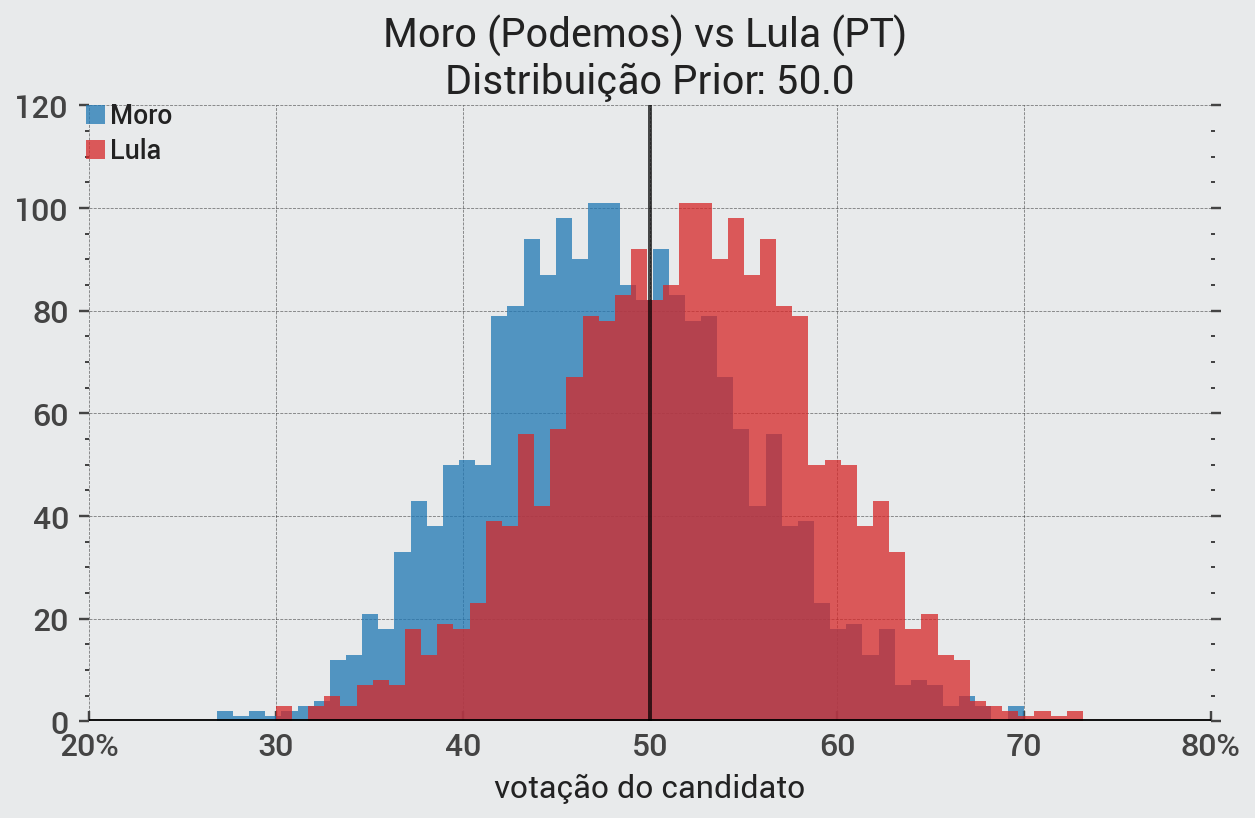

In [40]:
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.hist(1. - (lula_moro_prior['phi']), color='tab:blue', alpha=0.75, bins=50, label='Moro')
    ax.hist(lula_moro_prior['phi'], color='tab:red', alpha=0.75, bins=50, label='Lula')
    ax.set_title('Moro (Podemos) vs Lula (PT) \nDistribuição Prior: {}'.format(PRIOR_N), fontsize=20)
    ax.set_xlabel(f'votação do candidato')
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.axvline(x = 0.5, color = 'black', linewidth = 2, alpha = .7)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xticks(ticks = [.20, .30, .40, .50, .60, .70, .80])
    ax.set_xticklabels(labels = ['20%', '30', '40', '50', '60', '70', '80%'])
    #ax.grid(linestyle=':')
    ax.legend(loc="upper left")
    fig.tight_layout();
    # save figure 
    plt.savefig('../figures/moro_lula_{}-priors.png'.format(PRIOR_N))

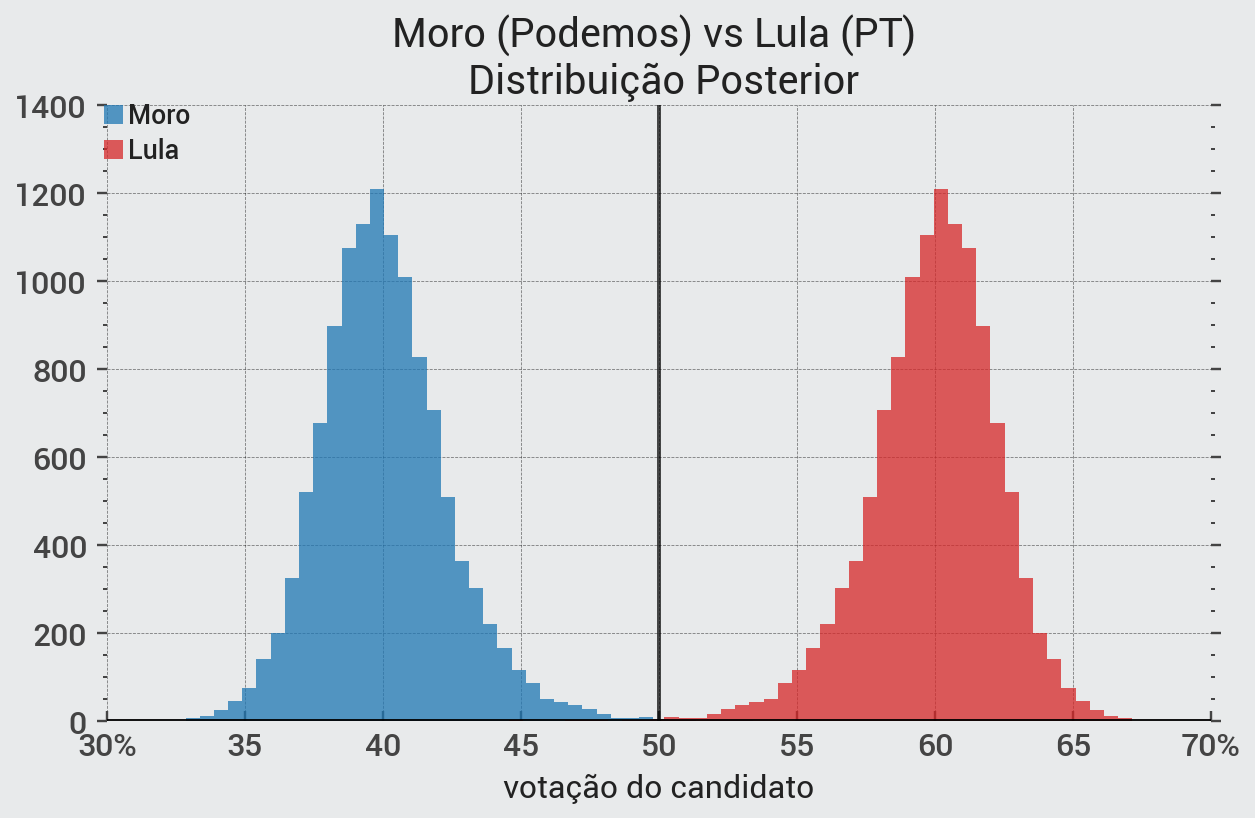

In [46]:
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.hist(1. - (lula_moro_samples['phi']), color='tab:blue', alpha=0.75, bins=50, label='Moro')
    ax.hist(lula_moro_samples['phi'], color='tab:red', alpha=0.75, bins=50, label='Lula')
    ax.set_title('Moro (Podemos) vs Lula (PT) \n Distribuição Posterior', fontsize=20)
    ax.set_xlabel(f'votação do candidato')
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.axvline(x = 0.5, color = 'black', linewidth = 2, alpha = .7)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xticks(ticks = [.30, .35, .40, .45, .50, .55, .60, .65, .70])
    ax.set_xticklabels(labels = ['30%', '35', '40', '45', '50', '55', '60', '65', '70%'])
    plt.xlim([0.30, 0.70])
    #ax.grid(linestyle=':')
    ax.legend(loc="upper left")
    fig.tight_layout();

plt.savefig('../figures/moro_lula_posteriors.png')

In [ ]:
print("Probabilidade de vitória de Lula no 2º turno:", round(np.mean(lula_moro_samples['phi'] > 0.50), 3));

print("Probabilidade de vitória de Moro no 2º turno:", round(np.mean(1. - lula_moro_samples['phi'] > 0.50), 3));